In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
import glob
import pathlib as pl
import salishsea_tools.geo_tools as gt

In [18]:
p1 = '/Users/arand/downloads/uas_NAM-22_ECMWF-ERAINT_evaluation_r1i1p1_CCCma-CanRCM4_r2_3hr_2007010103-2008010100.nc'
d1 = xr.open_dataset(p1)
p2 = '/Users/arand/downloads/vas_NAM-22_ECMWF-ERAINT_evaluation_r1i1p1_CCCma-CanRCM4_r2_3hr_2007010103-2008010100.nc'
d2 = xr.open_dataset(p2)


In [19]:
##print(d1)

In [20]:
A = d1['uas'][:, :, :]
B = d2['vas'][:, :, :]

print(A.shape)

(2920, 260, 310)


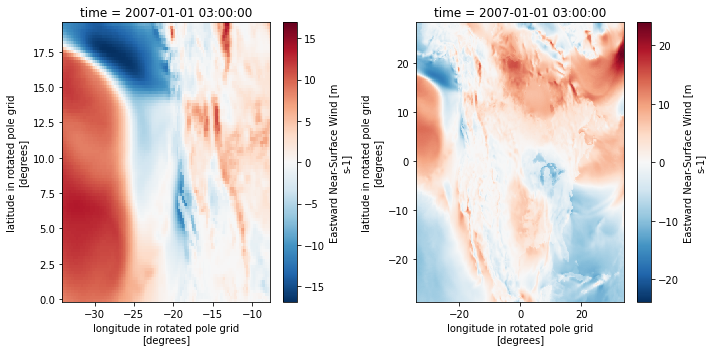

In [22]:
A = d1['uas'][:, 130:220, 0:120]
#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
A[0].plot(ax=axs[0])
d1.uas[0].plot(ax=axs[1])
fig.tight_layout()

In [23]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr)
    data3 = np.empty((arr.shape[1]*arr.shape[2], arr.shape[0])) 
    for i in range(arr.shape[0]):
        flattened_arr = arr[i,:,:].flatten(order = 'C')
        data3[:, i] = flattened_arr[:]; 
    return data3

##reverse does the inverse of transform
def reverse(arr, arr_orig):
    a = arr_orig.shape[1]
    b = arr_orig.shape[2]
    data4 = np.empty((arr.shape[1], a, b))
    for i in range(arr.shape[1]):
        temp = arr[:,i].reshape(a,b)
        data4[i,:,:] = temp
    arr_new = A.copy(data = data4) ##copies the metadata from A, and the data from data4
    return arr_new

In [24]:
A_mat = transform(A)
B_mat = transform(B)

##conducting PCA analysis on combined data matrix
pca = PCA(n_components = 10) ##adjust the number of principle conponents to be calculated
PCs = pca.fit_transform(A_mat)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
A_temp = pca.inverse_transform(pca.transform(A_mat))
A_new = reverse(A_temp, A)

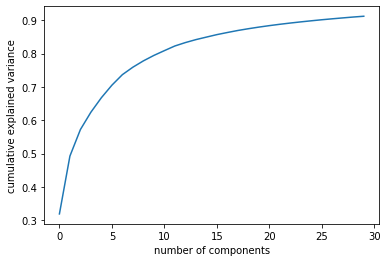

In [25]:
##graphing percentage of original data represented by the first n principle conponents

pcaG = PCA(n_components = 30) ##Number of principle conponents to show
PCsG = pcaG.fit_transform(A_mat)
plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [26]:
print(A.shape)

(2920, 90, 120)


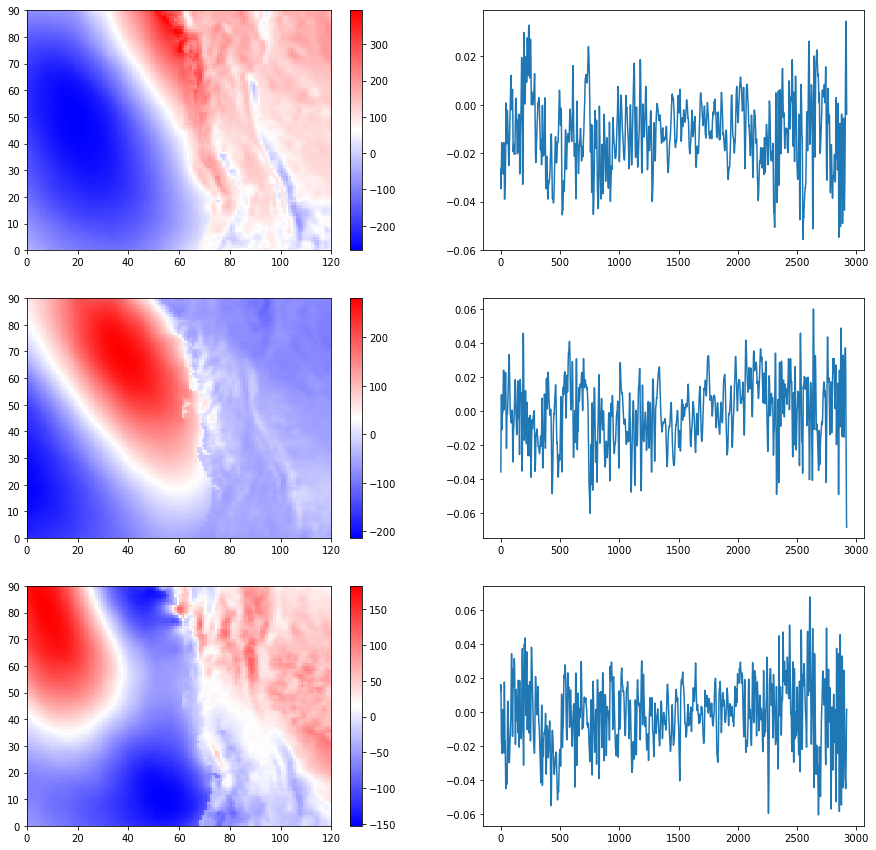

In [27]:
#displaying first 3 principle conponents  and time-loading
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
mode0 = PCs[:,0].reshape(A.shape[1], A.shape[2])
mode1 = PCs[:,1].reshape(A.shape[1], A.shape[2])
mode2 = PCs[:,2].reshape(A.shape[1], A.shape[2])

colors = ax[0, 0].pcolormesh(mode0, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,0])
ax[0, 1].plot(eigvecs[0])

colors = ax[1, 0].pcolormesh(mode1, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,0])
ax[1, 1].plot(eigvecs[1])

colors = ax[2, 0].pcolormesh(mode2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,0])
ax[2, 1].plot(eigvecs[2])